In [156]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [157]:
# Hyperparams
SEQ_LEN = 50
N_SAMPLES = 5000

In [158]:
# Create clean sine wave

x = np.linspace(0, 100, SEQ_LEN)
x_clean = np.array([np.sin(x + i) for i in range(N_SAMPLES)])
noise = 0.3 * np.random.randn(*x_clean.shape)
x_noise = x_clean + noise

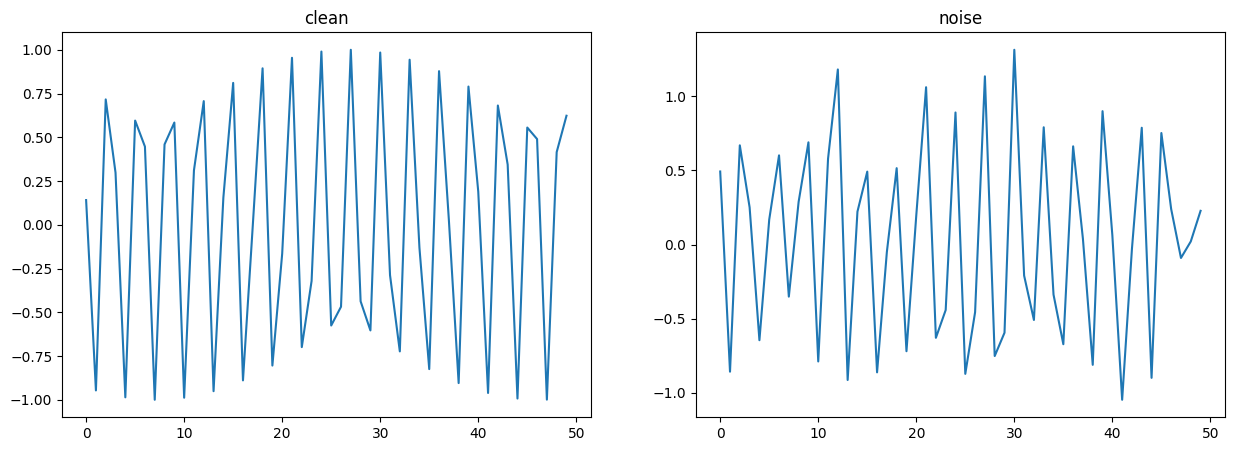

In [159]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('clean')
plt.plot(range(50),x_clean[3])

plt.subplot(1,2,2)
plt.title('noise')
plt.plot(range(50),x_noise[3])

In [160]:
# แบ่ง train + temp (val+test)
x_noise_train, x_noise_temp, x_clean_train, x_clean_temp = train_test_split(
    x_noise, x_clean, test_size=0.3, random_state=42)


# แบ่ง val และ test จาก temp
x_noise_val, x_noise_test, x_clean_val, x_clean_test = train_test_split(
    x_noise_temp, x_clean_temp, test_size=0.5, random_state=42)

In [161]:
from sklearn.preprocessing import MinMaxScaler

# --- reshape ให้เป็น 2D (เพราะ scaler ทำงานกับ 2D เท่านั้น) ---
x_clean_train_2d = x_clean_train.reshape(-1, 1)
x_noise_train_2d = x_noise_train.reshape(-1, 1)

# --- Fit scaler เฉพาะจาก train เท่านั้น (กัน leakage) ---
scaler = MinMaxScaler()
scaler.fit(x_clean_train_2d)

MinMaxScaler()

In [162]:
# แปลงเป็น tensor และเพิ่ม dimension ด้วย .unsqueeze(-1)
# เพราะ LSTM ต้องการ shape = (batch, seq_len, feature)
# ในที่นี้ feature = 1 (คือ ค่าของ signal แต่ละ timestep)
def scale_and_unsqueeze(x, scaler, original_shape):
    x_scaled = scaler.transform(x.reshape(-1, 1)).reshape(original_shape)
    return torch.tensor(x_scaled, dtype=torch.float32).unsqueeze(-1)  # → shape (batch, seq_len, 1)

x_clean_train = scale_and_unsqueeze(x_clean_train, scaler, x_clean_train.shape)
x_noise_train = scale_and_unsqueeze(x_noise_train, scaler, x_noise_train.shape)
x_clean_val   = scale_and_unsqueeze(x_clean_val, scaler, x_clean_val.shape)
x_noise_val   = scale_and_unsqueeze(x_noise_val, scaler, x_noise_val.shape)
x_clean_test  = scale_and_unsqueeze(x_clean_test, scaler, x_clean_test.shape)
x_noise_test  = scale_and_unsqueeze(x_noise_test, scaler, x_noise_test.shape)

In [163]:
x_noise_train.size()

torch.Size([3500, 50, 1])

In [164]:
batch_size = 32
train_loader = DataLoader(TensorDataset(x_noise_train, x_clean_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_noise_val, x_clean_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(x_noise_test, x_clean_test), batch_size=batch_size)

In [165]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 128

        # Encoder
        self.encoder_lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            batch_first=True
        )
        self.embedding = nn.Linear(self.hidden_dim, embedding_dim)

        # Decoder
        self.decoder_lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            batch_first=True
        )
        self.decoder_output = nn.Sequential(
            nn.Linear(self.hidden_dim, n_features),
            nn.Sigmoid()  # ✅ constrain output to [0, 1]
        )

        
    def forward(self, x):
        # x: (batch, seq_len, n_features)
        
        # Encode
        _, (hidden, _) = self.encoder_lstm(x)  # hidden: (num_layers * bidirectional=1, batch, embedding_dim)
        
        # Repeat latent vector seq_len times to feed decoder
        # hidden[-1]: (batch, embedding_dim)
        latent = hidden[-1] 
        latent_repeated = latent.unsqueeze(1).repeat(1, self.seq_len, 1) #ไม่เปลี่ยน จำนวน sample
        
        # Decode
        out, _ = self.decoder_lstm(latent_repeated)  # out: (batch, seq_len, n_features)
        return out, latent

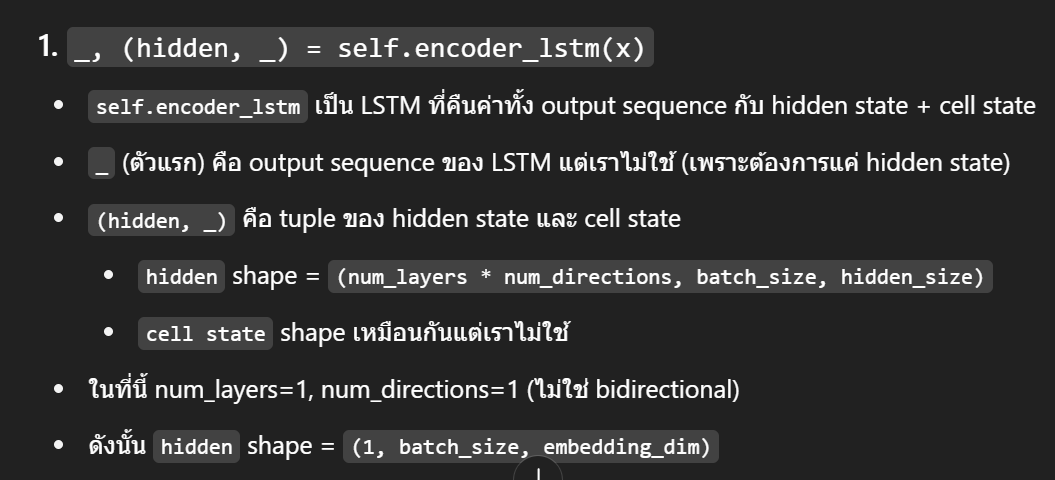

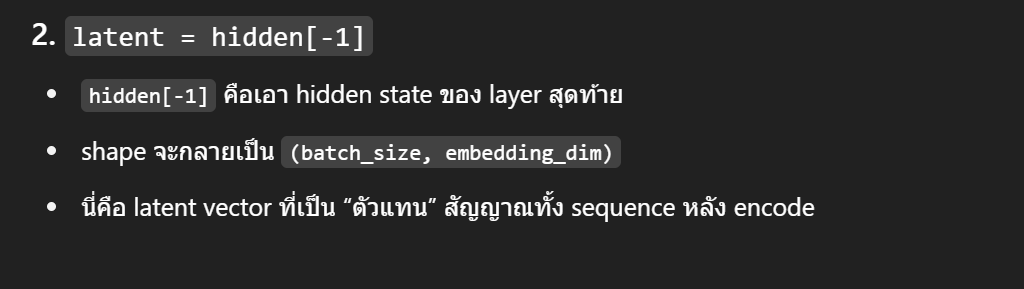

In [172]:
# Hyperparams
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMAutoencoder(seq_len=50, n_features=1, embedding_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [173]:
num_epochs = 50
train_losses = []
val_losses = []

In [174]:
for epoch in range(1, num_epochs + 1):
    # --- Train ---
    model.train()
    running_train_loss = 0
    for x_noisy, x_clean in train_loader:
        x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
        optimizer.zero_grad()
        outputs, _ = model(x_noisy)
        loss = criterion(outputs, x_clean)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * x_noisy.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for x_noisy, x_clean in val_loader:
            x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
            outputs, _ = model(x_noisy)
            loss = criterion(outputs, x_clean)
            running_val_loss += loss.item() * x_noisy.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch:02d}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 01/50 - Train Loss: 0.3715 - Val Loss: 0.3683
Epoch 02/50 - Train Loss: 0.3642 - Val Loss: 0.3600
Epoch 03/50 - Train Loss: 0.3539 - Val Loss: 0.3469
Epoch 04/50 - Train Loss: 0.3340 - Val Loss: 0.3144
Epoch 05/50 - Train Loss: 0.2464 - Val Loss: 0.1758
Epoch 06/50 - Train Loss: 0.1610 - Val Loss: 0.1499
Epoch 07/50 - Train Loss: 0.1425 - Val Loss: 0.1369
Epoch 08/50 - Train Loss: 0.1332 - Val Loss: 0.1310
Epoch 09/50 - Train Loss: 0.1296 - Val Loss: 0.1291
Epoch 10/50 - Train Loss: 0.1285 - Val Loss: 0.1284
Epoch 11/50 - Train Loss: 0.1280 - Val Loss: 0.1281
Epoch 12/50 - Train Loss: 0.1276 - Val Loss: 0.1278
Epoch 13/50 - Train Loss: 0.1274 - Val Loss: 0.1275
Epoch 14/50 - Train Loss: 0.1271 - Val Loss: 0.1273
Epoch 15/50 - Train Loss: 0.1269 - Val Loss: 0.1271
Epoch 16/50 - Train Loss: 0.1268 - Val Loss: 0.1269
Epoch 17/50 - Train Loss: 0.1266 - Val Loss: 0.1268
Epoch 18/50 - Train Loss: 0.1265 - Val Loss: 0.1267
Epoch 19/50 - Train Loss: 0.1263 - Val Loss: 0.1265
Epoch 20/50 

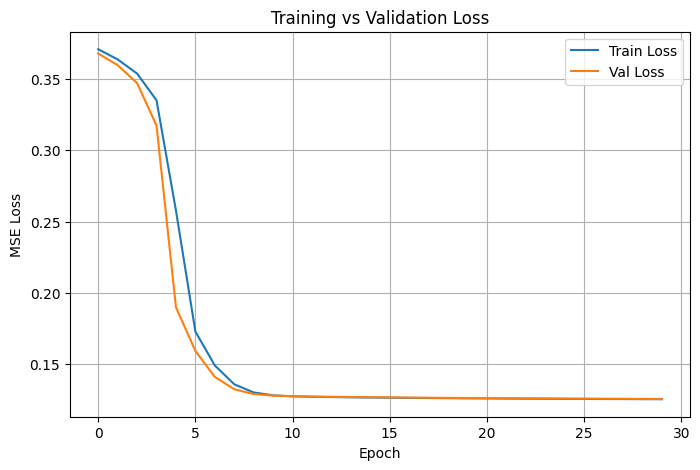

In [169]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

C:\Users\eieiz\AppData\Local\Temp\ipykernel_19868\184608586.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


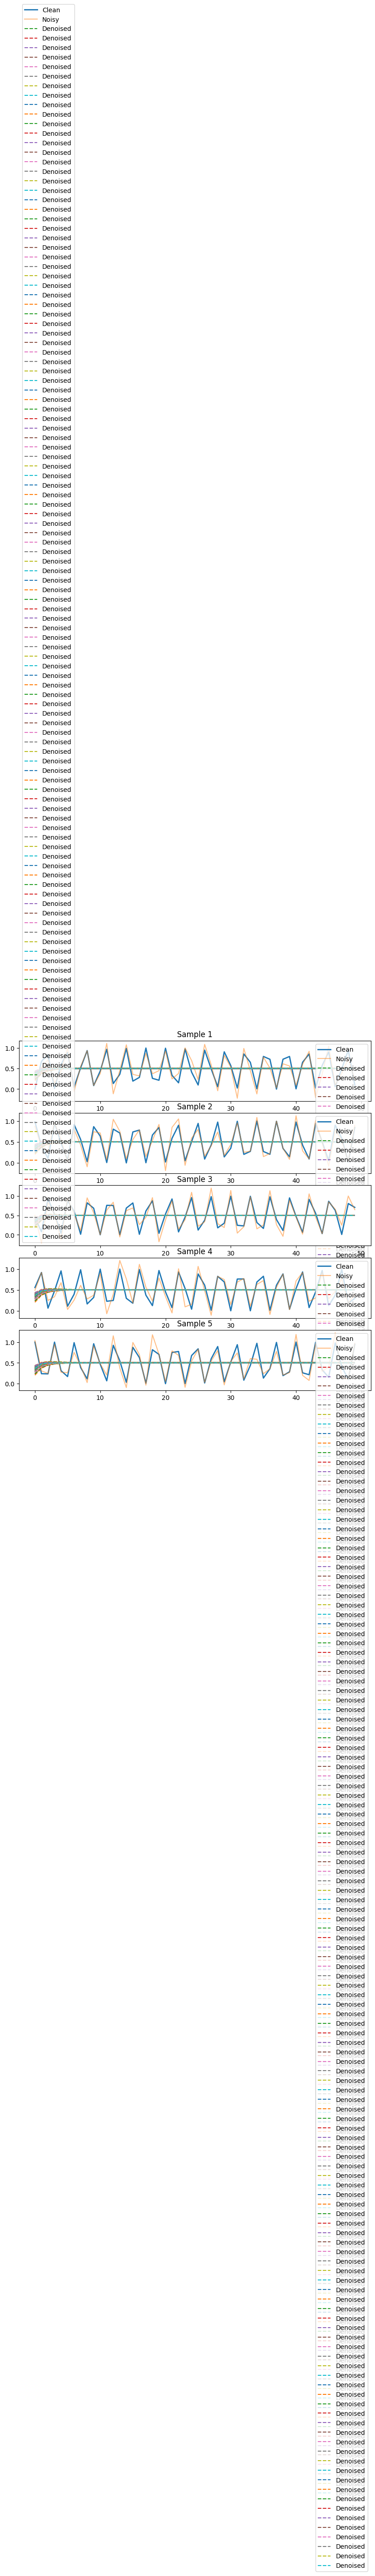

In [170]:
model.eval()

# เอา 5 ตัวอย่างจาก test set มาใช้
n_show = 5
x_noise_example, x_clean_example = next(iter(test_loader))
x_noise_example, x_clean_example = x_noise_example[:n_show].to(device), x_clean_example[:n_show].to(device)

with torch.no_grad():
    x_pred_example, _ = model(x_noise_example)

x_noise_example = x_noise_example.squeeze(-1).cpu().numpy()
x_clean_example = x_clean_example.squeeze(-1).cpu().numpy()
x_pred_example = x_pred_example.squeeze(-1).cpu().numpy()

# Plot
fig, axs = plt.subplots(n_show, 1, figsize=(10, 2 * n_show))

for i in range(n_show):
    axs[i].plot(x_clean_example[i], label="Clean", linewidth=2)
    axs[i].plot(x_noise_example[i], label="Noisy", alpha=0.5)
    axs[i].plot(x_pred_example[i], label="Denoised", linestyle="--")
    axs[i].set_title(f"Sample {i+1}")
    axs[i].legend()

plt.tight_layout()
plt.show()